# Capstone Project - The Battle of the Neighborhoods
## The Best Surf Spots

## Introduction

In this project, surf spots across the west coast of the US will be analyzed. 
A Surf Travel Company is looking for the best surf destination with:

* Nearby accommodation to good surf( for this case, it will be campgrounds).
* Campgrounds that is central to other nearby surf spots.


# Objective 
- The main objective is to create a new Travel product/service that will give the best destination for a surf trip.



In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

import matplotlib as mpl
import matplotlib.pyplot as plt

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

mpl.style.use('ggplot')

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#for kMeans Clustering
from sklearn.cluster import KMeans 

!pip install folium
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 112kB 11.4MB/s eta 0:00:01
Folium installed
Libraries imported.


# Data

The data that will be used are data coming from Surfline.com, a company that lists all the surf spots.
Foursquare will be used to find the nearest Campgrounds/Accomodation from the given surf spots.

* Data is parsed from Surfline.com using request from a Map that is freely accessible
* A Dataframe is created to include surfspots around the world
* Since we are mainly focused on the west coast of the US, a new dataframe is created using the same timezone. 
* Data extracted from the websites are, Time Zone, Surfspot name, Latitude and Longitude.

In [2]:
# Download Data from Surfline. 
# Data is scraped from an interactive map that contains data about surf spots around the world. 

url = 'https://services.surfline.com/kbyg/mapview?south=-5.7908968128719565&west=-190.01953125000003&north=70.08056215839737&east=-50.09765625000001&accesstoken=a86ee1e02392c18b0021eebb94499a03dd744d3c'
results = requests.get(url).json()
print('Item Downloaded')

#add wanted items for searching
spots = results['data']['spots']

#define the data frame columns
column_names = ['Name', 
                'Time Zone',
                'Latitude', 
                'Longitude']

#instantiate the dataframe
surfspots=pd.DataFrame(columns=column_names)

#loops data into data frame
#Items to add,
    #'waveHeight': {'human': False,'min': 2,'max': 3,'occasional': None,'humanRelation': 'Thigh to waist high',
    #waterTemp

for data in spots:
    name = data['name']
    timezone = data['timezone']
    lat = data['lat']
    lon = data['lon']
    
    surfspots = surfspots.append({'Name': name,
                                  'Time Zone' : timezone,
                                  'Latitude': lat, 
                                  'Longitude':lon}, ignore_index=True)


#Remove Values with Overview & Close-up
surfspots = surfspots[~surfspots.Name.str.contains('Overview')]
surfspots = surfspots[~surfspots.Name.str.contains('Close-up')]

#Create new DF for America/LosAngeles Time zones
LA_list = []
for index, row in surfspots.iterrows():
    if row['Time Zone'] == 'America/Los_Angeles':
       LA_list.append(row)
    
ca_df = pd.DataFrame(LA_list)
ca_df.reset_index(inplace=True)
ca_df.drop('index', axis=True, inplace=True)
#drop first row since it's not an actual data
ca_df.drop([0], inplace =True)

#Drop timezone since we know all the items in the dataframe is from the west coast
ca_df = ca_df.drop(['Time Zone'], axis =1)
print('completed script')



Item Downloaded
completed script


In [7]:
#Create Map of surfspots

#Center Area of the Map
address = 'Point Reyes, CA'

geolocator = Nominatim(user_agent="west_coast")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#Create Map of Surf Spots on the West Coast

west_coast_map = folium.Map(location=[latitude, longitude], zoom_start=5.5)

# add markers to map
for lat, lng, label in zip(ca_df['Latitude'], ca_df['Longitude'],ca_df['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(west_coast_map)  
    
west_coast_map
    

# Fourequare API
* Used to find the campgrounds near the surfspots.
* We are only interested in Campgrounds - a New Dataframe is created with the campgrounds.



In [8]:
# Get Nearby Venues around the surfspots. 

CLIENT_ID = 'L3V1SEM3IG2BW1X1N3M1L5UHQNMBEYSEVMB1154KXMR44VRZ'
CLIENT_SECRET = 'A1MZG44ENLPQYB4ZZC2K5ZSJI24I34ZJ5YKWYQEALGSBHIYR' 
VERSION = '20200101' 




def getNearbyVenues(names, latitudes, longitudes):
    radius=1000
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#Add surf spots to Venues nearby.
venues_nearsurf = getNearbyVenues (ca_df['Name'],ca_df['Latitude'],ca_df['Longitude'])

#Rename Neighborhood to Surfspot

venues_nearsurf = venues_nearsurf.rename(columns={'Neighborhood': 'Surfspots'})

print('completed')

Surf Beach
Jalama
Point Conception
Refugio
El Capitan
Sands
Devereux
Campus Point
Leadbetter Point
Leadbetter Beach
Sandspit
Santa Barbara Harbor
Hammond's
Carpinteria State Beach
Tarpits
Rincon
Mussel Shoals (aka Little Rincon)
Oil Piers
Stanley's
Pitas Point
Mondos
Solimar
Gold Coast Beachbreaks
Summer Beach
Emma Wood
Ventura Overhead
Ventura Point
C St.
Ventura Harbor
Oxnard
County Line
Leo Carrillo
Zuma Beach North
Zuma Beach
Westward Beach
Point Dume
Latigo Point
Malibu Second to Third Point
Malibu Surfrider Beach
Malibu First Point
Topanga Beach
Chart House
Sunset Point
Sunset Beach
Santa Monica Beach North
Santa Monica Pier, North
Santa Monica Pier
Bay St.
Santa Monica Beach South
Venice Breakwater
Venice Beach
Venice Pier, Northside
Venice Pier, Southside
Dockweiler State Beach
Shitpipe
Hammerland
El Porto Close Up North
El Porto North
El Porto Close Up South
El Porto
Manhattan Pier Northside
Manhattan Pier, Southside
Hermosa Beach
Hermosa Pier Northside
Hermosa Pier Southside


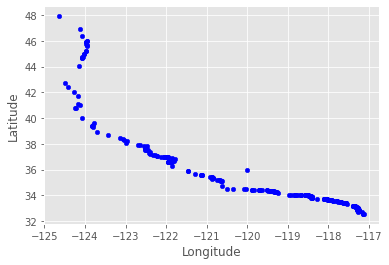

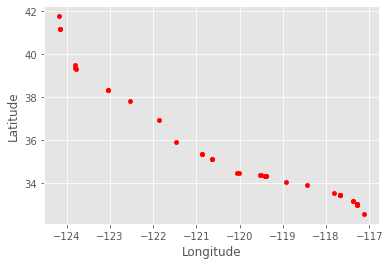

In [9]:

# create new DF just for Campgrounds nearby the surfspots 
acc_df=[]

for index, row in venues_nearsurf.iterrows():
    if row['Venue Category'] == ('Campground'): 
        acc_df.append(row)
        
#New DF just for Campgrounds - Also going to be the amount of clusters and the centroids        
campgrounds = pd.DataFrame(acc_df) 

# Rename Lat and Long 
campgrounds.rename(columns={'Neighborhood Latitude': 'Latitude', 'Neighborhood Longitude' : 'Longitude'}, inplace=True)
#pull surfnames to be new centroids. 
centroids = campgrounds.copy() #drop(['Venue', 'Venue Latitude','Venue Longitude', 'Venue Category'], axis = 1)
#centroids = centroids.drop_duplicates()
centroids = centroids.reset_index()
centroids = centroids.drop('index', axis =1)

#compare points of surfspots with campgrounds

ax1 = ca_df.plot.scatter(x='Longitude',  y='Latitude', c='blue')
ax2 = centroids.plot.scatter(x='Longitude',  y='Latitude', c='red')


#add points on map

# add campgrounds to map
for lat, lng, label in zip(centroids['Latitude'], centroids['Longitude'],centroids['Surfspots']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(west_coast_map)  

In [10]:
west_coast_map

# Methodology

So far we have gathered all the data needed. 
- Surf spots along the west coast with Latitudes and Longitudes
- Campgrounds nearby Surfspots with Latitudes and Longitudes 

Next we'll be analysing the data and clustering 

# k Mean Clustering for surfspots with campgrouds as centroids

In [16]:
locations = ca_df.loc[:,['Latitude', 'Longitude']]

startp = []
for lat, long in zip(centroids['Venue Latitude'],centroids['Venue Longitude']):
    startp.append([lat,lon])

points =np.array(startp)
k_clusters = len(centroids)
kmeans = KMeans(init=points, n_clusters=k_clusters, n_init=1).fit(locations)

cluster_labels = kmeans.labels_

#Insert Labels to main ca_df
ca_df.insert(0, 'Cluster Labels', kmeans.labels_)




/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (36) found smaller than n_clusters (37). Possibly due to duplicate points in X.
  return_n_iter=True)


In [17]:
# create map
surfmap = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ca_df['Latitude'], ca_df['Longitude'], ca_df['Name'], ca_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(surfmap)
       
surfmap

In [18]:
#INCLUDE CAMPGROUNDS in MAP

for lat, lng, label in zip(centroids['Venue Latitude'], centroids['Venue Longitude'],centroids['Venue']):
    label = folium.Popup(label)
    folium.Marker(
        [lat, lng],
        popup=label).add_to(surfmap)  

In [19]:
surfmap

# Create Maps with all the clusters
By creating a Dictionary. A for loop is created looping through each clustered items and adding it to a new Folium Map. 

In [28]:
#Create Maps for each cluster with Dictionary 'Surf Camp: n'
maps = {}

for campground in range(len(centroids)):
    tempholder = ca_df.loc[ca_df['Cluster Labels'] == campground]
    lat1 = centroids['Venue Latitude'].iloc[campground]
    lon1 = centroids['Venue Longitude'].iloc[campground]
    
    maps['Surf Camp: ' + str(campground)] = folium.Map(location=[lat1, lon1], zoom_start=12)
    
    for lat, lon, poi, cluster in zip(tempholder['Latitude'], tempholder['Longitude'], tempholder['Name'], tempholder['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Surf Spot ')
        folium.Marker([lat, lon]).add_to(maps['Surf Camp: ' + str(campground)])
        folium.Marker([lat1, lon1], popup = centroids['Venue'].iloc[campground],icon=folium.Icon(icon='home')).add_to(maps['Surf Camp: ' + str(campground)])

# Results 
- We can see that there are 37 total surf spots with campgrounds that have close surfspots.
- We can look at each campgrounds and find the nearest surf spots. 

In [29]:
len(maps)

37

# Surf Camp: 1

In [30]:
maps['Surf Camp: 1']

# Surf Camp: 4

In [33]:
maps['Surf Camp: 4']

# Surf Camp: 7

In [35]:
maps['Surf Camp: 7']